In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from PIL import Image
import seaborn as sns
from itertools import cycle
import numpy as np
import pandas as pd
import os
import sys
import json

from rich.jupyter import display

sns.reset_orig()
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from models import log_parabolic_spectrum
from catalogue import load_catalogue
from plots import MARKER_TYPES
from cycler import cycler

# Set the output directories here
outdir_st = 'outdir_b_all_cauchy'
outdir_aic = 'outdir_a_all'

# line style cycle
line_sets = ['-', '--', ':', '-.']
color_sets = ['k', 'tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'c', 'y']

Hobbs et al. (2004): 453 measurements
Counts of specific relative uncertainties:
- ~10%: 173 (38.2%)
- ~20%: 10 (2.2%)
- ~50%: 1 (0.2%)
Jankowski et al. (2018): 881 measurements
Counts of specific relative uncertainties:
- ~10%: 42 (4.8%)
- ~20%: 60 (6.8%)
- ~50%: 24 (2.7%)
Johnston & Kerr (2018): 585 measurements
Counts of specific relative uncertainties:
- ~10%: 0 (0.0%)
- ~20%: 227 (38.8%)
- ~50%: 0 (0.0%)
Posselt et al. (2023): 9459 measurements
Counts of specific relative uncertainties:
- ~10%: 488 (5.2%)
- ~20%: 69 (0.7%)
- ~50%: 2 (0.0%)
All: 22986 measurements
Counts of specific relative uncertainties:
- ~10%: 1470 (6.4%)
- ~20%: 814 (3.5%)
- ~50%: 2693 (11.7%)


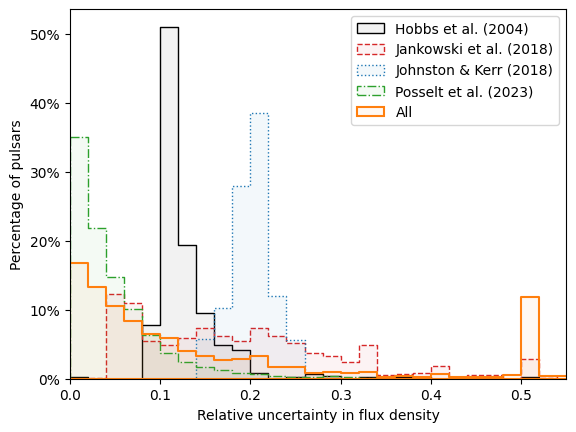

In [2]:
catalogue = load_catalogue(outdir_st)
    
fig, ax = plt.subplots()
line_cycler = cycle(line_sets)
color_cycler = cycle(color_sets)

def uncertainty_distribution(ref_name: str, caption: str = None, ax=ax, binwidth=0.02, binrange=(0, 0.55)):
    if caption is None and ref_name in catalogue.citation_dict:
        caption = catalogue.citation_dict[ref_name]
    else:
        caption = ref_name
        
    selected_Ys = []
    selected_YERRs = []
    for jname in catalogue.cat_dict.keys():
        if ref_name == 'All':
            selected_Ys.extend(catalogue.cat_dict[jname]['Y'])
            selected_YERRs.extend(catalogue.cat_dict[jname]['YERR'])
        else:
            if ref_name in catalogue.cat_dict[jname]['REF']:
                for i, ref in enumerate(catalogue.cat_dict[jname]['REF']):
                    if ref == ref_name:
                        selected_Ys.append(catalogue.cat_dict[jname]['Y'][i])
                        selected_YERRs.append(catalogue.cat_dict[jname]['YERR'][i])
    
    selected_Ys = np.array(selected_Ys)
    selected_YERRs = np.array(selected_YERRs)
    YERR_Y = selected_YERRs / selected_Ys
    print(f'{caption}: {len(selected_Ys)} measurements')
    
    cosru_10 = np.sum((YERR_Y >= 0.1-0.01) & (YERR_Y < 0.1+0.01))
    cosru_20 = np.sum((YERR_Y >= 0.2-0.01) & (YERR_Y < 0.2+0.01))
    cosru_50 = np.sum((YERR_Y >= 0.5-0.01) & (YERR_Y < 0.5+0.01))
    print('Counts of specific relative uncertainties:')
    print(f'- ~10%: {cosru_10} ({cosru_10 / len(YERR_Y):.1%})')
    print(f'- ~20%: {cosru_20} ({cosru_20 / len(YERR_Y):.1%})')
    print(f'- ~50%: {cosru_50} ({cosru_50 / len(YERR_Y):.1%})')
    
    sns.histplot(YERR_Y, binwidth=binwidth, binrange=binrange,
                 kde=False, label=caption, ax=ax, alpha=0.05, color=next(color_cycler),
                 stat='probability', element='step', linestyle=next(line_cycler), linewidth=1.5 if ref_name == 'All' else 1)
    
uncertainty_distribution('Hobbs_2004a', ax=ax)
uncertainty_distribution('Jankowski_2018', ax=ax)
uncertainty_distribution('Johnston_2018', ax=ax)
uncertainty_distribution('Posselt_2023', ax=ax)
uncertainty_distribution('All', ax=ax)
ax.set_xlim(0, 0.55)
ax.set_xlabel('Relative uncertainty in flux density')
ax.set_ylabel('Percentage of pulsars')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.legend()
plt.savefig('Uncertainty distribution.pdf', bbox_inches='tight')
plt.show()

In [19]:
def load_results(outdir: str, var: str):
    with open(f'../output/results_{var}_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
        results = pd.DataFrame(json.load(f)).T
    with open(f'../output/results_good_fit_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
        good_fit_results = pd.DataFrame(json.load(f)).T  # table of true/false
        # transform good_fit_results to array of bools
        good_fit_results = good_fit_results.applymap(lambda x: x == 'True')
        
    # set result to NaN if the fit is not good
    results = results.where(good_fit_results)
    
    # best_fitting column
    results['best_fitting'] = results.idxmax(axis=1) if var == 'log_evidence' else results.idxmin(axis=1)
    
    # if all columns are NaN, set best_fitting to '(Unclassified)'
    results['best_fitting'] = results['best_fitting'].fillna('(Unclassified)')
    return results
results_st = load_results(outdir_st, 'log_evidence')
results_aic = load_results(outdir_aic, 'aic')
    
results_st_bf = results_st[results_st['best_fitting'] != '(Unclassified)'].drop(columns='best_fitting')
results_st_bf = results_st_bf.sub(results_st_bf['simple_power_law'], axis=0).drop(columns='simple_power_law')
results_st_decisive = results_st_bf[results_st_bf > 3.].any(axis=1)
with open(f'../output/results_decisive_from_{outdir_st}.json', 'w', encoding='utf-8-sig') as f:
    json.dump(results_st_decisive.to_dict(), f, ensure_ascii=False, indent=4)

with open(f'../output/results_param_estimates_from_{outdir_st}.json', 'r', encoding='utf-8-sig') as f:
    param_est = json.load(f)
with open(f'../output/results_param_estimates_from_{outdir_aic}.json', 'r', encoding='utf-8-sig') as f:
    param_est_aic = json.load(f)
    
msp_list = open(f'../catalogue/msps.txt', 'r', encoding='utf-8-sig').read().strip().splitlines()

In [20]:
spl_alpha_best, spl_alpha_not_worst, spl_alpha_best_aic = [], [], []
spl_alpha_msp_best, spl_alpha_nmsp_best = [], []
for jname in results_st.index:
    if jname in param_est and 'simple_power_law' in param_est[jname] and jname in results_st_bf.index:
        alpha = param_est[jname]['simple_power_law']['median'][0]
        if results_st.loc[jname, 'best_fitting'] == 'simple_power_law':
            spl_alpha_best.append(alpha)
            if jname in msp_list:
                spl_alpha_msp_best.append(alpha)
            else:
                spl_alpha_nmsp_best.append(alpha)
        if jname in results_st_decisive.index and not results_st_decisive[jname]:  # if other models are not decisively better than the simple power law
            spl_alpha_not_worst.append(alpha)
    if jname in results_aic.index and results_aic.loc[jname, 'best_fitting'] == 'simple_power_law':
        alpha = param_est_aic[jname]['simple_power_law']['median'][0]
        spl_alpha_best_aic.append(alpha)
            
lftopl_alpha_best, hfcopl_alpha_best = [], []
for jname in results_st.index:
    if jname in param_est and 'low_frequency_turn_over_power_law' in param_est[jname] and results_st.loc[jname, 'best_fitting'] == 'low_frequency_turn_over_power_law':
        alpha = param_est[jname]['low_frequency_turn_over_power_law']['median'][1]
        lftopl_alpha_best.append(alpha)
    if jname in param_est and 'high_frequency_cut_off_power_law' in param_est[jname] and results_st.loc[jname, 'best_fitting'] == 'high_frequency_cut_off_power_law':
        alpha = param_est[jname]['high_frequency_cut_off_power_law']['median'][1]
        hfcopl_alpha_best.append(alpha)
        

Number of pulsars with simple power law as the best fitting model: 257
Number of pulsars with simple power law not decisively worst: 543
Number of pulsars with simple power law as the best fitting model (AIC): 234


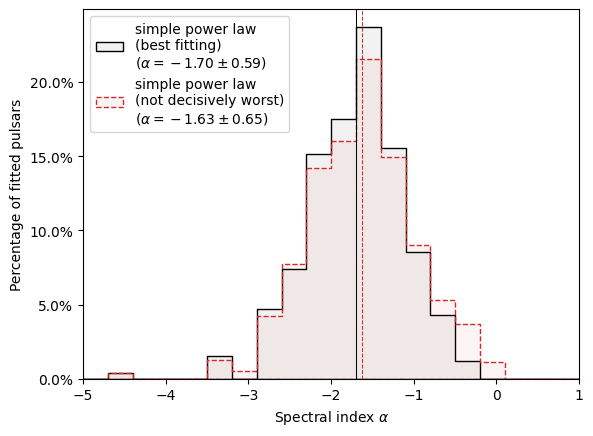

In [21]:
print(f'Number of pulsars with simple power law as the best fitting model: {len(spl_alpha_best)}')
print(f'Number of pulsars with simple power law not decisively worst: {len(spl_alpha_not_worst)}')
print(f'Number of pulsars with simple power law as the best fitting model (AIC): {len(spl_alpha_best_aic)}')
        
fig, ax = plt.subplots()
line_cycler, line_cycler2 = cycle(line_sets), cycle(line_sets)
color_cycler, color_cycler2 = cycle(color_sets), cycle(color_sets)

sns.histplot(spl_alpha_best, binwidth=0.3, binrange=(-5., 1.), kde=False, label=f'simple power law\n(best fitting)\n($α = {np.mean(spl_alpha_best):.2f} \pm {np.std(spl_alpha_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler))
sns.histplot(spl_alpha_not_worst, binwidth=0.3, binrange=(-5., 1.), kde=False, label=f'simple power law\n(not decisively worst)\n($α = {np.mean(spl_alpha_not_worst):.2f} \pm {np.std(spl_alpha_not_worst):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler))
# sns.histplot(spl_alpha_best_aic, binwidth=0.3, binrange=(-5., 1.), kde=False, label=f'simple power law\n(best fitting, AIC)\n($α = {np.mean(spl_alpha_best_aic):.2f} \pm {np.std(spl_alpha_best_aic):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)
ylim = ax.get_ylim()
ax.vlines(np.mean(spl_alpha_best), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.75)
ax.vlines(np.mean(spl_alpha_not_worst), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.75)
# ax.vlines(np.mean(spl_alpha_best_aic), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.75)
ax.set_ylim(ylim)
ax.set_xlabel('Spectral index $α$')
ax.set_ylabel('Percentage of fitted pulsars')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlim(-5., 1.)
ax.legend(loc='upper left')
plt.savefig('Spectral index distribution (simple power law).pdf', bbox_inches='tight')
plt.show()

Number of pulsars with simple power law as the best fitting model: 257
Number of pulsars with low-frequency turn-over power law as the best fitting model: 208
Number of pulsars with high-frequency cut-off power law as the best fitting model: 27


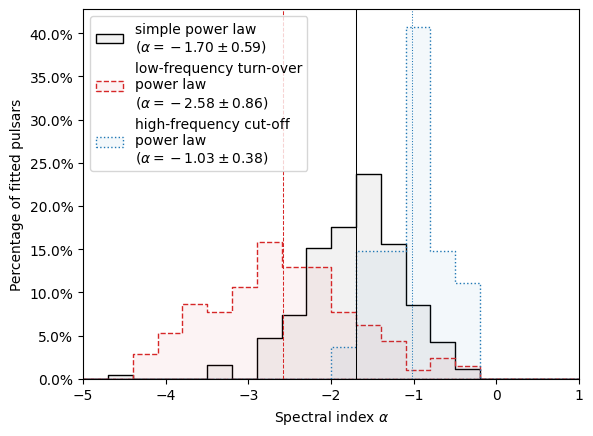

In [22]:
fig, ax = plt.subplots()
line_cycler, line_cycler2 = cycle(line_sets), cycle(line_sets)
color_cycler, color_cycler2 = cycle(color_sets), cycle(color_sets)

print(f'Number of pulsars with simple power law as the best fitting model: {len(spl_alpha_best)}')
print(f'Number of pulsars with low-frequency turn-over power law as the best fitting model: {len(lftopl_alpha_best)}')
print(f'Number of pulsars with high-frequency cut-off power law as the best fitting model: {len(hfcopl_alpha_best)}')

sns.histplot(spl_alpha_best, binwidth=0.3, binrange=(-5., 1.), kde=False, label=f'simple power law\n($α = {np.mean(spl_alpha_best):.2f} \pm {np.std(spl_alpha_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler))
sns.histplot(lftopl_alpha_best, binwidth=0.3, binrange=(-5., 1.), kde=False, label=f'low-frequency turn-over\npower law\n($α = {np.mean(lftopl_alpha_best):.2f} \pm {np.std(lftopl_alpha_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler))
sns.histplot(hfcopl_alpha_best, binwidth=0.3, binrange=(-5., 1.), kde=False, label=f'high-frequency cut-off\npower law\n($α = {np.mean(hfcopl_alpha_best):.2f} \pm {np.std(hfcopl_alpha_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler))

ylim = ax.get_ylim()
ax.vlines(np.mean(spl_alpha_best), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.75)
ax.vlines(np.mean(lftopl_alpha_best), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.75)
ax.vlines(np.mean(hfcopl_alpha_best), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.75)
ax.set_ylim(ylim)
ax.set_xlabel('Spectral index $α$')
ax.set_ylabel('Percentage of fitted pulsars')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlim(-5., 1.)
ax.legend(loc='upper left')
plt.savefig('Spectral index distribution (comparison).pdf', bbox_inches='tight')
plt.show()

Number of MSPs with simple power law as the best fitting model: 29
Number of non-MSPs with simple power law as the best fitting model: 228


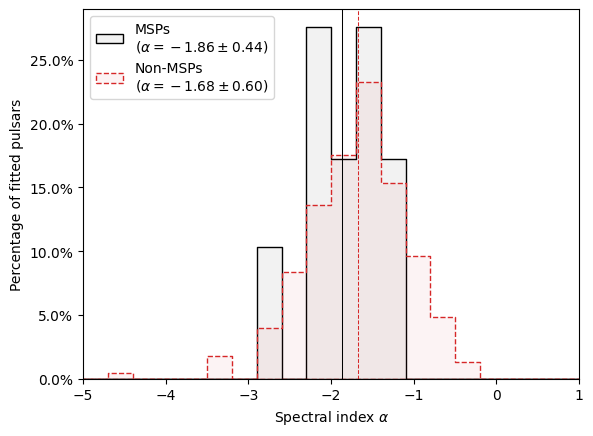

In [23]:
print(f'Number of MSPs with simple power law as the best fitting model: {len(spl_alpha_msp_best)}')
print(f'Number of non-MSPs with simple power law as the best fitting model: {len(spl_alpha_nmsp_best)}')

fig, ax = plt.subplots()
line_cycler, line_cycler2 = cycle(line_sets), cycle(line_sets)
color_cycler, color_cycler2 = cycle(color_sets), cycle(color_sets)

sns.histplot(spl_alpha_msp_best, binwidth=0.3, binrange=(-5., 1.), kde=False, label=f'MSPs\n($α = {np.mean(spl_alpha_msp_best):.2f} \pm {np.std(spl_alpha_msp_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler))
sns.histplot(spl_alpha_nmsp_best, binwidth=0.3, binrange=(-5., 1.), kde=False, label=f'Non-MSPs\n($α = {np.mean(spl_alpha_nmsp_best):.2f} \pm {np.std(spl_alpha_nmsp_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler))

ylim = ax.get_ylim()
ax.vlines(np.mean(spl_alpha_msp_best), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.75)
ax.vlines(np.mean(spl_alpha_nmsp_best), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.75)
ax.set_ylim(ylim)
ax.set_xlabel('Spectral index $α$')
ax.set_ylabel('Percentage of fitted pulsars')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlim(-5., 1.)
ax.legend(loc='upper left')
plt.savefig('Spectral index distribution (MSP vs non-MSP).pdf', bbox_inches='tight')
plt.show()

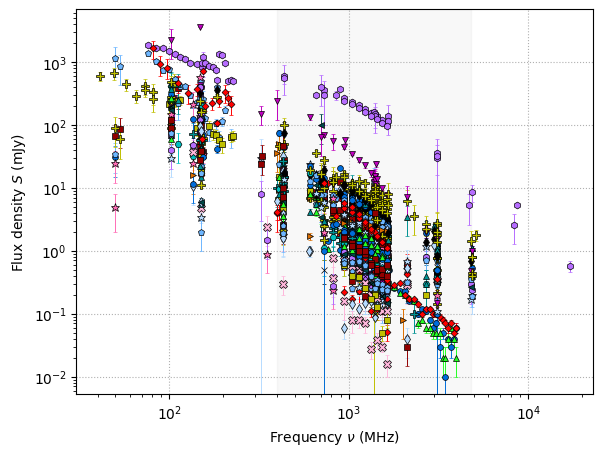

In [24]:
fig, ax = plt.subplots(figsize=(5*4/3, 5))
ax.set_yscale('log')
ax.set_xscale('log')
custom_cycler = (cycler(color = [p[0] for p in MARKER_TYPES])
                + cycler(marker = [p[1] for p in MARKER_TYPES])
                + cycler(markersize = np.array([p[2] for p in MARKER_TYPES])*.7))
ax.set_prop_cycle(custom_cycler)
prop_cycle = ax._get_lines.prop_cycler
for jname, data in catalogue.items():
    if jname not in msp_list:
        continue
    ax.errorbar(data['X'], data['Y'], yerr=data['YERR'],
                linestyle='None',
                mec='k',
                markeredgewidth=.5,
                elinewidth=.7,
                capsize=1.5,
                **next(prop_cycle))
    # X_sorted = np.sort(data['X'])
    # Y_sorted = np.array([data['Y'][np.where(data['X'] == x)[0][0]] for x in X_sorted])
    # ax.plot(X_sorted, Y_sorted, **next(prop_cycle))
ax.grid(linestyle=':')
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# 0.4 GHz to 4.8 GHz fill
ax.fill_between([0.4e3, 4.8e3], *ylim, color='tab:gray', alpha=0.05, label='0.4 GHz to 4.8 GHz')

ax.set_xlabel('Frequency $ν$ (MHz)')
ax.set_ylabel('Flux density $S$ (mJy)')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.show()

In [25]:
bpl_turnovers = []
lftopl_turnovers = []
hfcopl_turnovers = []
dtos_lfturnovers, dtos_hfturnovers = [], []
lps_turnovers = []

msp_bpl_turnovers = []
msp_lftopl_turnovers = []
msp_hfcopl_turnovers = []
msp_dtos_lfturnovers, msp_dtos_hfturnovers = [], []
msp_lps_turnovers = []

for jname in results_st.index:
    if jname in param_est and 'broken_power_law' in param_est[jname] and results_st.loc[jname, 'best_fitting'] == 'broken_power_law':
        v_b = param_est[jname]['broken_power_law']['median'][0]
        bpl_turnovers.append(v_b)
        if jname in msp_list:
            msp_bpl_turnovers.append(v_b)
    if jname in param_est and 'low_frequency_turn_over_power_law' in param_est[jname] and results_st.loc[jname, 'best_fitting'] == 'low_frequency_turn_over_power_law':
        v_c = param_est[jname]['low_frequency_turn_over_power_law']['median'][0]
        lftopl_turnovers.append(v_c)
        if jname in msp_list:
            msp_lftopl_turnovers.append(v_c)
    if jname in param_est and 'high_frequency_cut_off_power_law' in param_est[jname] and results_st.loc[jname, 'best_fitting'] == 'high_frequency_cut_off_power_law':
        v_c = param_est[jname]['high_frequency_cut_off_power_law']['median'][0]
        hfcopl_turnovers.append(v_c)
        if jname in msp_list:
            msp_hfcopl_turnovers.append(v_c)
    if jname in param_est and 'double_turn_over_spectrum' in param_est[jname] and results_st.loc[jname, 'best_fitting'] == 'double_turn_over_spectrum':
        v_c1 = param_est[jname]['double_turn_over_spectrum']['median'][0]
        v_c2 = param_est[jname]['double_turn_over_spectrum']['median'][1]
        dtos_hfturnovers.append(v_c1)
        dtos_lfturnovers.append(v_c2)
        if jname in msp_list:
            msp_dtos_hfturnovers.append(v_c1)
            msp_dtos_lfturnovers.append(v_c2)
    if jname in param_est and 'log_parabolic_spectrum' in param_est[jname] and results_st.loc[jname, 'best_fitting'] == 'log_parabolic_spectrum':
        pulsar = catalogue.get_pulsar(jname)
        a = param_est[jname]['log_parabolic_spectrum']['median'][0]
        b = param_est[jname]['log_parabolic_spectrum']['median'][1]
        c = param_est[jname]['log_parabolic_spectrum']['median'][2]
        x = np.logspace(np.log10(np.min(pulsar.X)), np.log10(np.max(pulsar.X)), 1000)
        y = log_parabolic_spectrum(x, {'a': a, 'b': b, 'c': c}, pulsar.v0)
        v_turnover = x[np.argmax(y)] if a > 0 else x[np.argmin(y)]
        lps_turnovers.append(v_turnover)
        if jname in msp_list:
            msp_lps_turnovers.append(v_turnover)

Number of pulsars with broken power law as the best fitting model: 299
Number of pulsars with high-frequency cut-off power law as the best fitting model: 27
Number of pulsars with low-frequency turn-over power law as the best fitting model: 208
Number of pulsars with double turn-over spectrum as the best fitting model: 56
Number of pulsars with log-parabolic spectrum as the best fitting model: 27


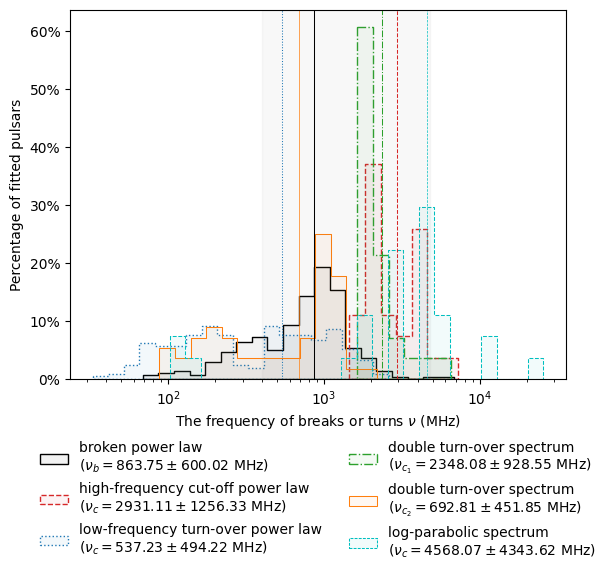

In [26]:
print(f'Number of pulsars with broken power law as the best fitting model: {len(bpl_turnovers)}')
print(f'Number of pulsars with high-frequency cut-off power law as the best fitting model: {len(hfcopl_turnovers)}')
print(f'Number of pulsars with low-frequency turn-over power law as the best fitting model: {len(lftopl_turnovers)}')
print(f'Number of pulsars with double turn-over spectrum as the best fitting model: {len(dtos_lfturnovers)}')
print(f'Number of pulsars with log-parabolic spectrum as the best fitting model: {len(lps_turnovers)}')

fig, ax = plt.subplots()
line_cycler, line_cycler2 = cycle(line_sets), cycle(line_sets)
color_cycler, color_cycler2 = cycle(color_sets), cycle(color_sets)

sns.histplot(bpl_turnovers, binwidth=0.1, binrange=None, log_scale=True, kde=False, label=f'broken power law\n($ν_b = {np.mean(bpl_turnovers):.2f} \pm {np.std(bpl_turnovers):.2f}$ MHz)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler))
sns.histplot(hfcopl_turnovers, binwidth=0.1, binrange=None, log_scale=True, kde=False, label=f'high-frequency cut-off power law\n($ν_c = {np.mean(hfcopl_turnovers):.2f} \pm {np.std(hfcopl_turnovers):.2f}$ MHz)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler))
sns.histplot(lftopl_turnovers, binwidth=0.1, binrange=None, log_scale=True, kde=False, label=f'low-frequency turn-over power law\n($ν_c = {np.mean(lftopl_turnovers):.2f} \pm {np.std(lftopl_turnovers):.2f}$ MHz)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler))
sns.histplot(dtos_hfturnovers, binwidth=0.1, binrange=None, log_scale=True, kde=False, label=f'double turn-over spectrum\n($ν_{{c_1}} = {np.mean(dtos_hfturnovers):.2f} \pm {np.std(dtos_hfturnovers):.2f}$ MHz)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler))
sns.histplot(dtos_lfturnovers, binwidth=0.1, binrange=None, log_scale=True, kde=False, label=f'double turn-over spectrum\n($ν_{{c_2}} = {np.mean(dtos_lfturnovers):.2f} \pm {np.std(dtos_lfturnovers):.2f}$ MHz)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler), linewidth=0.75)
sns.histplot(lps_turnovers, binwidth=0.1, binrange=None, log_scale=True, kde=False, label=f'log-parabolic spectrum\n($ν_c = {np.mean(lps_turnovers):.2f} \pm {np.std(lps_turnovers):.2f}$ MHz)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler), linewidth=0.75)

ylim = ax.get_ylim()
ax.vlines(np.mean(bpl_turnovers), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.75)
ax.vlines(np.mean(hfcopl_turnovers), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.75)
ax.vlines(np.mean(lftopl_turnovers), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.75)
ax.vlines(np.mean(dtos_hfturnovers), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.75)
ax.vlines(np.mean(dtos_lfturnovers), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.5)
ax.vlines(np.mean(lps_turnovers), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.5)

# 0.4 GHz to 4.8 GHz fill
ax.fill_between([0.4e3, 4.8e3], *ylim, color='tab:gray', alpha=0.05)

ax.set_ylim(ylim)
ax.set_xscale('log')
ax.set_xlabel('The frequency of breaks or turns $ν$ (MHz)')
ax.set_ylabel('Percentage of fitted pulsars')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, borderaxespad=0., frameon=False)
plt.savefig('Turn frequency distribution.pdf', bbox_inches='tight')
plt.show()

Number of MSPs with broken power law as the best fitting model: 29
Number of MSPs with high-frequency cut-off power law as the best fitting model: 4
Number of MSPs with low-frequency turn-over power law as the best fitting model: 21
Number of MSPs with double turn-over spectrum as the best fitting model: 0
Number of MSPs with log-parabolic spectrum as the best fitting model: 2


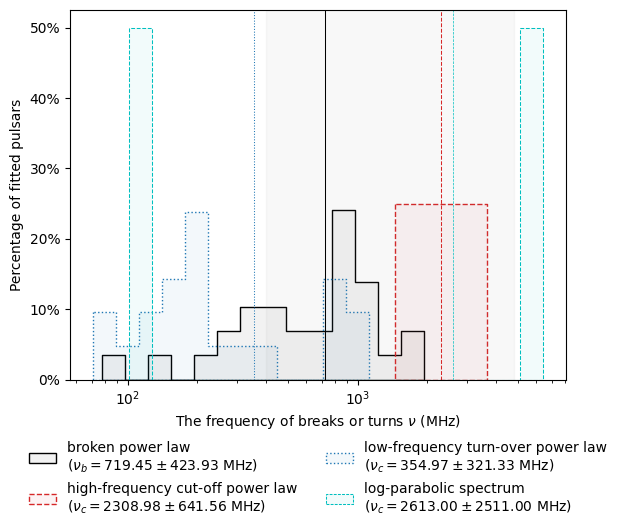

In [27]:
print(f'Number of MSPs with broken power law as the best fitting model: {len(msp_bpl_turnovers)}')
print(f'Number of MSPs with high-frequency cut-off power law as the best fitting model: {len(msp_hfcopl_turnovers)}')
print(f'Number of MSPs with low-frequency turn-over power law as the best fitting model: {len(msp_lftopl_turnovers)}')
print(f'Number of MSPs with double turn-over spectrum as the best fitting model: {len(msp_dtos_lfturnovers)}')
print(f'Number of MSPs with log-parabolic spectrum as the best fitting model: {len(msp_lps_turnovers)}')

fig, ax = plt.subplots()
line_cycler, line_cycler2 = cycle(line_sets), cycle(line_sets)
color_cycler, color_cycler2 = cycle(color_sets), cycle(color_sets)

sns.histplot(msp_bpl_turnovers, binwidth=0.1, binrange=None, log_scale=True, kde=False, label=f'broken power law\n($ν_b = {np.mean(msp_bpl_turnovers):.2f} \pm {np.std(msp_bpl_turnovers):.2f}$ MHz)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler))
sns.histplot(msp_hfcopl_turnovers, binwidth=0.1, binrange=None, log_scale=True, kde=False, label=f'high-frequency cut-off power law\n($ν_c = {np.mean(msp_hfcopl_turnovers):.2f} \pm {np.std(msp_hfcopl_turnovers):.2f}$ MHz)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler))
sns.histplot(msp_lftopl_turnovers, binwidth=0.1, binrange=None, log_scale=True, kde=False, label=f'low-frequency turn-over power law\n($ν_c = {np.mean(msp_lftopl_turnovers):.2f} \pm {np.std(msp_lftopl_turnovers):.2f}$ MHz)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler))
sns.histplot(msp_dtos_hfturnovers, binwidth=0.1, binrange=None, log_scale=True, kde=False, label=f'double turn-over spectrum\n($ν_{{c_1}} = {np.mean(msp_dtos_hfturnovers):.2f} \pm {np.std(msp_dtos_hfturnovers):.2f}$ MHz)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler))
sns.histplot(msp_dtos_lfturnovers, binwidth=0.1, binrange=None, log_scale=True, kde=False, label=f'double turn-over spectrum\n($ν_{{c_2}} = {np.mean(msp_dtos_lfturnovers):.2f} \pm {np.std(msp_dtos_lfturnovers):.2f}$ MHz)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler), linewidth=0.75)
sns.histplot(msp_lps_turnovers, binwidth=0.1, binrange=None, log_scale=True, kde=False, label=f'log-parabolic spectrum\n($ν_c = {np.mean(msp_lps_turnovers):.2f} \pm {np.std(msp_lps_turnovers):.2f}$ MHz)', ax=ax, stat='probability', element='step', alpha=0.05, color=next(color_cycler), linestyle=next(line_cycler), linewidth=0.75)

ylim = ax.get_ylim()
ax.vlines(np.mean(msp_bpl_turnovers), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.75)
ax.vlines(np.mean(msp_hfcopl_turnovers), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.75)
ax.vlines(np.mean(msp_lftopl_turnovers), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.75)
ax.vlines(np.mean(msp_dtos_hfturnovers), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.75)
ax.vlines(np.mean(msp_dtos_lfturnovers), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.5)
ax.vlines(np.mean(msp_lps_turnovers), *ylim, color=next(color_cycler2), linestyle=next(line_cycler2), linewidth=0.5)

# 0.4 GHz to 4.8 GHz fill
ax.fill_between([0.4e3, 4.8e3], *ylim, color='tab:gray', alpha=0.05)

ax.set_ylim(ylim)
ax.set_xscale('log')
ax.set_xlabel('The frequency of breaks or turns $ν$ (MHz)')
ax.set_ylabel('Percentage of fitted pulsars')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, borderaxespad=0., frameon=False)
plt.savefig('Turn frequency distribution (MSPs).pdf', bbox_inches='tight')
plt.show()

In [28]:
SHOW_PLOTS = False

if SHOW_PLOTS:
    def get_plot(jname: str, model: str):
        file_path = f'../output/{outdir_st}/{jname}/{model}_result.png'
        if not os.path.exists(file_path):
            return
        image = Image.open(file_path)
        image.show()
    
    # get all simple power law pulsars
    spl_best_jnames = []
    for jname in results_st.index:
        if jname in param_est and 'simple_power_law' in param_est[jname] and results_st.loc[jname, 'best_fitting'] == 'simple_power_law':
            spl_best_jnames.append(jname)
    
    for jname in spl_best_jnames:
        get_plot(jname, 'simple_power_law')

In [29]:
SHOW_PLOTS = False
INTERACTIVE = False
if INTERACTIVE:
    %matplotlib notebook
    import mplcursors

def get_plots(jname: str, models: list):
    images = []
    for i, model in enumerate(models):
        file_path = f'../output/{outdir_st}/{jname}/{model}_result.png'
        if not os.path.exists(file_path):
            continue
        images.append(Image.open(file_path))
    if len(images) > 0:
        Image.fromarray(np.hstack([np.array(image) for image in images])).show()

def plot_aa_scatter(x, y, bf: list, jnames: list, model_name, xlabel, ylabel, xlim = None, ylim = None, title = '', legend_loc='best', ext_out: float=5.):
    fig, ax = plt.subplots()
    scatters, plot_jnames, plot_info = [], [], []
    for i in range(len(x)):
        if abs(y[i] - x[i] + np.median(x) - np.median(y)) > ext_out:
            plot_jnames.append(jnames[i])
            plot_info.append(f'Outlier {jnames[i]}: α_x = {x[i]:.2f}, α_y = {y[i]:.2f}, ln BF = {bf[i]:.2f}')
        #     scatter = plt.scatter(x[i], y[i], s=bf[i] * 2, color='tab:blue', alpha=0.5)
        # else:
        scatter = plt.scatter(x[i], y[i], s=bf[i] * 2, color='k', alpha=0.2)
        scatters.append(scatter)
    if INTERACTIVE and jnames is not None:
        cursor = mplcursors.cursor(scatters, hover=True)
        def get_label(sel):
            ix = np.where(np.array(scatters) == sel.artist)[0][0]
            sel.annotation.set_text(f'{jnames[ix]}\nln BF = {bf[ix]:.2f}\nx = {x[ix]:.2f}\ny = {y[ix]:.2f}')
        cursor.connect('add', get_label)
            
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
        
    # draw a hidden point to show the scatter plot in the legend
    plt.scatter([], [], s=50, alpha=0.2, color='k', label='Spectral indices (scaled\nby log Bayes factor)')
    # plt.scatter([], [], s=50, alpha=0.5, color='r', label='Extreme outliers')
    
    plt.plot([-20, 20], [-20, 20], color='tab:red', linestyle='--', label='Identity')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    ax.set_aspect('equal', adjustable='datalim')
    plt.legend(loc=legend_loc)
    plt.savefig(f'{title}.pdf', bbox_inches='tight')
    plt.show()
    
    for info, jname in zip(plot_info, plot_jnames):
        print(info)
        if SHOW_PLOTS:
            get_plots(jname, ['simple_power_law', model_name])
    
def aa_scatter(model_name: str, model_name_cap: str, interactive=False, ext_out: float=5.):
    x, y, bf, jnames = [], [], [], []
    for jname in results_st.index:
        if 'simple_power_law' in results_st.columns and model_name in results_st.columns and jname in param_est and 'simple_power_law' in param_est[jname] and model_name in param_est[jname] and results_st.loc[jname, 'best_fitting'] == model_name:
            # If more than half of the points are on the left side of the turn-over, then the simple power law would most likely fit the left side of the plot, thus the comparison becomes pointless.
            turn_over_freq = param_est[jname]['low_frequency_turn_over_power_law']['median'][0]
            X = np.array(catalogue.cat_dict[jname]['X'])
            if np.sum(X < turn_over_freq) / len(X) > 0.5:
                continue
            
            x.append(param_est[jname][model_name]['median'][1])
            y.append(param_est[jname]['simple_power_law']['median'][0])
            bf.append(results_st.loc[jname, model_name] - results_st.loc[jname, 'simple_power_law'])
            jnames.append(jname)
    
    print(f'Number of pulsars with {model_name_cap} as the best fitting model: {len(x)}')
    
    plot_aa_scatter(x, y, model_name=model_name,
                    xlabel=f'{model_name_cap.capitalize()} spectral index $α$',
                    ylabel='Simple power law spectral index $α$',
                    title=f'Spectral index comparison (simple power law vs {model_name_cap})',
                    bf=bf, jnames=jnames,
                    legend_loc='lower right', ext_out=ext_out)
    
aa_scatter('low_frequency_turn_over_power_law', 'low-frequency turn-over power law', interactive=INTERACTIVE, ext_out=2.)
aa_scatter('high_frequency_cut_off_power_law', 'high-frequency cut-off power law', interactive=INTERACTIVE, ext_out=2.)

Number of pulsars with low-frequency turn-over power law as the best fitting model: 191


ValueError: need at least one array to concatenate

Error in callback <function _draw_all_if_interactive at 0x000001BF1835E160> (for post_execute):


ValueError: need at least one array to concatenate

ValueError: need at least one array to concatenate

<Figure size 640x480 with 1 Axes>

In [30]:
print('GPS pulsars: peak frequency ∈ [0.6, 2.] GHz, and flux densities decreasing at lower frequencies')

kijak_2021_gps = ['J1302-6350', 'J1550-5418', 'J1622-4950', 'J1644-4559', 'J1702-4128', 'J1705-3950', 'J1718-3825', 'J1723-3659', 'J1739-3023', 'J1740+1000', 'J1741-3016', 'J1743-3150', 'J1745-2900', 'J1747-2958', 'J1751-3323', 'J1753-2502', 'J1757-2421', 'J1757-2223', 'J1803-2137', 'J1806-1154', 'J1809-1917', 'J1822-1400', 'J1825-1446', 'J1826-1334', 'J1832-0827', 'J1833-0827', 'J1835-1020', 'J1841-0345', 'J1845-0743', 'J1852-0635', 'J1901+0510', 'J1907+0918', 'J2007+2722']
pulsars = {}
for jname in results_st.index:
    pulsar = catalogue.get_pulsar(jname)
    observed_peak = pulsar.peak_frequency
    pulsars[jname] = {
        'kijak_2021_gps': jname in kijak_2021_gps,
        'observed_peak': observed_peak,
        'observed_gps': 0.6e3 <= observed_peak <= 2.e3 and np.min(pulsar.X) < observed_peak < np.max(pulsar.X),
        'model': results_st.loc[jname, 'best_fitting'],
        'model_peak': None,
        'model_gps': False,
    }
    if pulsars[jname]['model'] == 'broken_power_law' and jname in param_est and 'broken_power_law' in param_est[jname]:
        v_b = param_est[jname]['broken_power_law']['median'][0]
        alpha_1 = param_est[jname]['broken_power_law']['median'][1]
        alpha_2 = param_est[jname]['broken_power_law']['median'][2]
        pulsars[jname]['model_peak'] = v_b
        pulsars[jname]['model_gps'] = 0.6e3 <= v_b <= 2.e3 and alpha_1 > 0 > alpha_2
    if pulsars[jname]['model'] == 'low_frequency_turn_over_power_law' and jname in param_est and 'low_frequency_turn_over_power_law' in param_est[jname]:
        v_c = param_est[jname]['low_frequency_turn_over_power_law']['median'][0]
        alpha = param_est[jname]['low_frequency_turn_over_power_law']['median'][1]
        pulsars[jname]['model_peak'] = v_c
        pulsars[jname]['model_gps'] = 0.6e3 <= v_c <= 2.e3 and alpha < 0
    if pulsars[jname]['model'] == 'double_turn_over_spectrum' and jname in param_est and 'double_turn_over_spectrum' in param_est[jname]:
        v_c2 = param_est[jname]['double_turn_over_spectrum']['median'][1]
        alpha = param_est[jname]['double_turn_over_spectrum']['median'][2]
        pulsars[jname]['model_peak'] = v_c2
        pulsars[jname]['model_gps'] = 0.6e3 <= v_c2 <= 2.e3 and alpha < 0
    if pulsars[jname]['model'] == 'log_parabolic_spectrum' and jname in param_est and 'log_parabolic_spectrum' in param_est[jname]:
        # calculate the peak manually
        x = np.logspace(np.log10(np.min(pulsar.X)), np.log10(np.max(pulsar.X)), 1000)
        params = {'a': param_est[jname]['log_parabolic_spectrum']['median'][0],
                  'b': param_est[jname]['log_parabolic_spectrum']['median'][1],
                  'c': param_est[jname]['log_parabolic_spectrum']['median'][2]}
        y = log_parabolic_spectrum(x, params, pulsar.v0)
        model_peak = x[np.argmax(y)]  # find the peak frequency
        pulsars[jname]['model_peak'] = model_peak
        pulsars[jname]['model_gps'] = 0.6e3 <= model_peak <= 2.e3 and np.min(pulsar.X) < model_peak < np.max(pulsar.X)

pulsars = pd.DataFrame(pulsars).T
pulsars.index.name = 'PSRJ'
pulsars.to_csv('Pulsars_GPS.csv')

gps_pulsars_observed = pulsars[pulsars['observed_gps']].copy()
gps_pulsars_model = pulsars[pulsars['model_gps']].copy()
N = len(pulsars)
display(pd.DataFrame({
    'Total': {
        'Observed': f'{len(gps_pulsars_observed)} / {N} = {len(gps_pulsars_observed) / N:.1%}',
        'Model': f'{len(gps_pulsars_model)} / {N} = {len(gps_pulsars_model) / N:.1%}',
    },
    'Broken power law': {
        'Observed': f'{len(gps_pulsars_observed[gps_pulsars_observed["model"] == "broken_power_law"])} / {len(pulsars[pulsars["model"] == "broken_power_law"])} = {len(gps_pulsars_observed[gps_pulsars_observed["model"] == "broken_power_law"]) / len(pulsars[pulsars["model"] == "broken_power_law"]):.1%}',
        'Model': f'{len(gps_pulsars_model[gps_pulsars_model["model"] == "broken_power_law"])} / {len(pulsars[pulsars["model"] == "broken_power_law"])} = {len(gps_pulsars_model[gps_pulsars_model["model"] == "broken_power_law"]) / len(pulsars[pulsars["model"] == "broken_power_law"]):.1%}',
    },
    'Low-frequency turn-over power law': {
        'Observed': f'{len(gps_pulsars_observed[gps_pulsars_observed["model"] == "low_frequency_turn_over_power_law"])} / {len(pulsars[pulsars["model"] == "low_frequency_turn_over_power_law"])} = {len(gps_pulsars_observed[gps_pulsars_observed["model"] == "low_frequency_turn_over_power_law"]) / len(pulsars[pulsars["model"] == "low_frequency_turn_over_power_law"]):.1%}',
        'Model': f'{len(gps_pulsars_model[gps_pulsars_model["model"] == "low_frequency_turn_over_power_law"])} / {len(pulsars[pulsars["model"] == "low_frequency_turn_over_power_law"])} = {len(gps_pulsars_model[gps_pulsars_model["model"] == "low_frequency_turn_over_power_law"]) / len(pulsars[pulsars["model"] == "low_frequency_turn_over_power_law"]):.1%}',
    },
    'Double turn-over spectrum': {
        'Observed': f'{len(gps_pulsars_observed[gps_pulsars_observed["model"] == "double_turn_over_spectrum"])} / {len(pulsars[pulsars["model"] == "double_turn_over_spectrum"])} = {len(gps_pulsars_observed[gps_pulsars_observed["model"] == "double_turn_over_spectrum"]) / len(pulsars[pulsars["model"] == "double_turn_over_spectrum"]):.1%}',
        'Model': f'{len(gps_pulsars_model[gps_pulsars_model["model"] == "double_turn_over_spectrum"])} / {len(pulsars[pulsars["model"] == "double_turn_over_spectrum"])} = {len(gps_pulsars_model[gps_pulsars_model["model"] == "double_turn_over_spectrum"]) / len(pulsars[pulsars["model"] == "double_turn_over_spectrum"]):.1%}',
    },
    'Log-parabolic spectrum': {
        'Observed': f'{len(gps_pulsars_observed[gps_pulsars_observed["model"] == "log_parabolic_spectrum"])} / {len(pulsars[pulsars["model"] == "log_parabolic_spectrum"])} = {len(gps_pulsars_observed[gps_pulsars_observed["model"] == "log_parabolic_spectrum"]) / len(pulsars[pulsars["model"] == "log_parabolic_spectrum"]):.1%}',
        'Model': f'{len(gps_pulsars_model[gps_pulsars_model["model"] == "log_parabolic_spectrum"])} / {len(pulsars[pulsars["model"] == "log_parabolic_spectrum"])} = {len(gps_pulsars_model[gps_pulsars_model["model"] == "log_parabolic_spectrum"]) / len(pulsars[pulsars["model"] == "log_parabolic_spectrum"]):.1%}',
    },
}).T)

gps_pulsars_both = gps_pulsars_observed[gps_pulsars_observed['model_gps']].copy()
open('../catalogue/gps_pulsars.txt', 'w', encoding='utf-8-sig').write('\n'.join(gps_pulsars_both.index))
display(gps_pulsars_both)

# (observed_gps and model_gps) = False, kijak_2021_gps = True
kijak_2021_gps_not_in_classification = pulsars[(~(pulsars['observed_gps'] & pulsars['model_gps'])) & pulsars['kijak_2021_gps']].copy()
print(f'GPS pulsars in Kijak et al. (2021) but not in our classification: {len(kijak_2021_gps_not_in_classification)}')
display(kijak_2021_gps_not_in_classification)

GPS pulsars: peak frequency ∈ [0.6, 2.] GHz, and flux densities decreasing at lower frequencies


,Observed,Model
Total,149 / 882 = 16.9%,161 / 882 = 18.3%
Broken power law,48 / 299 = 16.1%,55 / 299 = 18.4%
Low-frequency turn-over power law,51 / 208 = 24.5%,73 / 208 = 35.1%
Double turn-over spectrum,14 / 56 = 25.0%,31 / 56 = 55.4%
Log-parabolic spectrum,0 / 27 = 0.0%,2 / 27 = 7.4%


,kijak_2021_gps,observed_peak,observed_gps,model,model_peak,model_gps
PSRJ,,,,,,
J0900-3144,False,944.609375,True,low_frequency_turn_over_power_law,798.464734,True
J0901-4624,False,944.0,True,double_turn_over_spectrum,1278.120418,True
J0908-4913,False,945.0,True,low_frequency_turn_over_power_law,752.230965,True
J1015-5719,False,1038.0,True,broken_power_law,967.764351,True
J1019-5749,False,1523.0,True,low_frequency_turn_over_power_law,1714.016565,True
...,...,...,...,...,...,...
J1917+0834,False,943.0,True,broken_power_law,773.845125,True
J2007+2722,True,1041.578125,True,low_frequency_turn_over_power_law,991.99861,True
J2124-3358,False,730.0,True,broken_power_law,982.408496,True


GPS pulsars in Kijak et al. (2021) but not in our classification: 16


,kijak_2021_gps,observed_peak,observed_gps,model,model_peak,model_gps
PSRJ,,,,,,
J1702-4128,True,610.0,True,low_frequency_turn_over_power_law,536.828275,False
J1739-3023,True,610.0,False,broken_power_law,2025.695847,False
J1740+1000,True,149.0,False,broken_power_law,723.610939,True
J1741-3016,True,584.0,False,double_turn_over_spectrum,1028.026151,True
J1743-3150,True,147.5,False,low_frequency_turn_over_power_law,479.152129,False
J1747-2958,True,1280.0,True,(Unclassified),None,False
J1757-2223,True,348.0,False,double_turn_over_spectrum,1154.291203,True
J1757-2421,True,408.0,False,broken_power_law,574.793348,False
J1809-1917,True,4920.0,False,low_frequency_turn_over_power_law,1100.263391,True


In [31]:
print('Broken power law: how many of them are having only one point before or after ν_b?', end=' ')

cnt_bpl, cnt_bpl_filtered = 0, 0
for jname in results_st.index:
    if results_st.loc[jname, 'best_fitting'] == 'broken_power_law':
        cnt_bpl += 1
        ν_b = param_est[jname]['broken_power_law']['median'][0]
        X_sorted = np.sort(catalogue.cat_dict[jname]['X'])
        if np.sum(X_sorted < ν_b) <= 1 or np.sum(X_sorted > ν_b) <= 1:
            cnt_bpl_filtered += 1
print(f'{cnt_bpl_filtered} / {cnt_bpl}.')

print('Low-frequency turn-over power law: how many of them are having only one point before or after ν_c?', end=' ')

cnt_lfto, cnt_lfto_filtered = 0, 0
for jname in results_st.index:
    if results_st.loc[jname, 'best_fitting'] == 'low_frequency_turn_over_power_law':
        cnt_lfto += 1
        ν_c = param_est[jname]['low_frequency_turn_over_power_law']['median'][0]
        X_sorted = np.sort(catalogue.cat_dict[jname]['X'])
        if np.sum(X_sorted < ν_c) <= 1 or np.sum(X_sorted > ν_c) <= 1:
            cnt_lfto_filtered += 1
print(f'{cnt_lfto_filtered} / {cnt_lfto}.')

print('Double turn-over spectrum: how many of them are having only one point before or after ν_c2?', end=' ')

cnt_dtos, cnt_dtos_filtered = 0, 0
for jname in results_st.index:
    if results_st.loc[jname, 'best_fitting'] == 'double_turn_over_spectrum':
        cnt_dtos += 1
        ν_c2 = param_est[jname]['double_turn_over_spectrum']['median'][0]
        X_sorted = np.sort(catalogue.cat_dict[jname]['X'])
        if np.sum(X_sorted < ν_c2) <= 1 or np.sum(X_sorted > ν_c2) <= 1:
            cnt_dtos_filtered += 1
print(f'{cnt_dtos_filtered} / {cnt_dtos}.')

Broken power law: how many of them are having only one point before or after ν_b? 61 / 299.
Low-frequency turn-over power law: how many of them are having only one point before or after ν_c? 71 / 208.
Double turn-over spectrum: how many of them are having only one point before or after ν_c2? 46 / 56.
